#### Unsupervised machine learning using the K-means clustering algorithm.

In [366]:
# import necessasry libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

##### Exploratory data analysis

In [367]:
# import the dataset
df = pd.read_csv("Mall_Customers.csv")

df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [368]:
df.shape

(200, 5)

In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


###### We have 0 null values.
##### Variables description:
###### CustomerID: Unique customer identifier.
###### Gender: Customer gender.
###### Age: Customer age.
###### Annual Income (k$): Customer's annual income in k$.
###### CSpending Score (1-100): A score assigned to each customer that reflects their level of spending.

##### Summary descriptive statistics of the numerical variables

In [370]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


##### Taking a closer look at the categorical variable 'Gender'

In [371]:
# Count the different values (category names)
df.Genre.value_counts()

Genre
Female    112
Male       88
Name: count, dtype: int64

In [372]:
# Rename the features to convenient ones
df.rename(columns={'Genre':'Gender', 'Annual Income (k$)':'Annual_Income', 'Spending Score (1-100)':'Spending_Score'}, inplace=True) 

# Remove CustomerID as it's not relevant for our study.
# Create a backup copy of the dataframe before removing the CustomerID.
df_backup = df.copy()
df.drop(columns = 'CustomerID', inplace = True)


df.head()

,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


##### Checking for outliers

##### What is the Outlier Formula?
The outlier formula, also known as the 1.5 IQR rule, is a rule of thumb used for identifying outliers. Outliers are extreme values that lie far from the other values in the data set.

The outlier formula designates outliers based on an upper and lower boundary (you can think of these as cutoff points). Any value that is 1.5 x IQR greater than the third quartile is designated as an outlier and any value that is 1.5 x IQR less than the first quartile is also designated as an outlier.

![Alt text](outliers_formula.svg)



In [373]:
# The function receives a dataframe and a column name and returns the quartiles.
def get_iqr_values(df_in, col_name):
    median_value = df_in[col_name].median() # The median.
    q1 = df_in[col_name].quantile(0.25) # The 1st quartile.
    q3 = df_in[col_name].quantile(0.75) # The 3rd quartile.
    iqr = q3-q1 # The interquartile range.
    lower_bound = q1 - 1.5*iqr # The minimum (marked |- in the boxplot).
    upper_bound = q3 + 1.5*iqr # The maximum (marked -| in the boxplot).
    return median_value, q1, q3, iqr, lower_bound, upper_bound

# The function receives a dataframe and the name of the column and returns the text formatted with the data from the get_iqr_values function.
def get_iqr_text(df_in, col_name):
    median_value, q1, q3, iqr, lower_bound, upper_bound = get_iqr_values(df_in, col_name)
    text = f"median={median_value:.2f}, q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}, lower_bound={lower_bound:.2f}, upper_bound={upper_bound:.2f}"
    return text

# The function receives a dataframe and the column name and returns the dataframe without the outliers.
def remove_outliers(df_in, col_name):
    _, _, _, _, lower_bound, upper_bound = get_iqr_values(df_in, col_name)
    df_out = df_in.loc[(df_in[col_name] > lower_bound) & (df_in[col_name] < upper_bound)]
    return df_out

# The function receives a dataframe and the name of the column and returns the number of outliers in the column.
def count_outliers(df_in, col_name):
    _, _, _, _, lower_bound, upper_bound = get_iqr_values(df_in, col_name)
    df_outliers = df_in.loc[(df_in[col_name] <= lower_bound) | (df_in[col_name] >= upper_bound)]
    return df_outliers.shape[0]

# The function receives the name of a dataframe and the name of a column and plots a boxplot.
def boxplot(df_in, col_name):
    title = get_iqr_text(df_in, col_name)
    sns.boxplot(df_in[col_name], orient = 'h', color="mediumslateblue")
    plt.title(title)
    plt.show()
    
# The function receives a dataframe and iterates through each of the numeric columns to remove all outliers or up to a maximum of 
# 100 iterations, returns the dataframe without the outliers, and displays the number of outliers removed.
def remove_all_outliers(df_in):
    columns=df.select_dtypes(include=['float64','int64']).columns
    totalOutliers=0
    for col_name in columns:
        iterations = 0
        outlier_count = count_outliers(df_in, col_name)
        
        while outlier_count > 0:
            iterations += 1

            if (iterations > 100):
                print("Number of outliers > 100. Breaking out of the loop")
                break  
            
            totalOutliers += count_outliers(df_in, col_name)
            df_in = remove_outliers(df_in, col_name)
            outlier_count = count_outliers(df_in, col_name)  
            
    print(totalOutliers, "Outliers removed",)
    return df_in



Age has 0 outliers


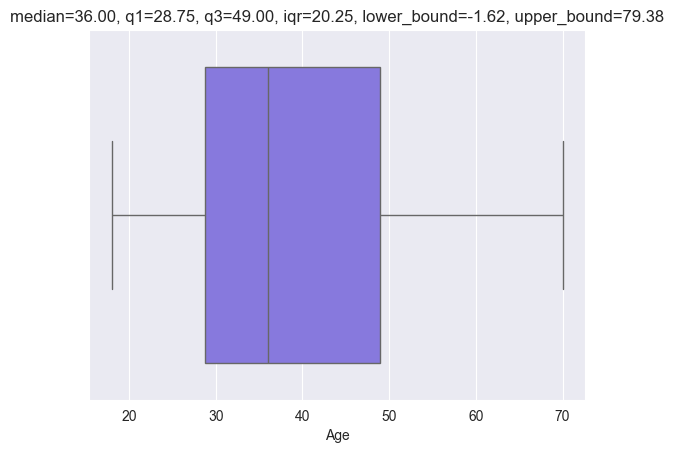

Annual_Income has 2 outliers


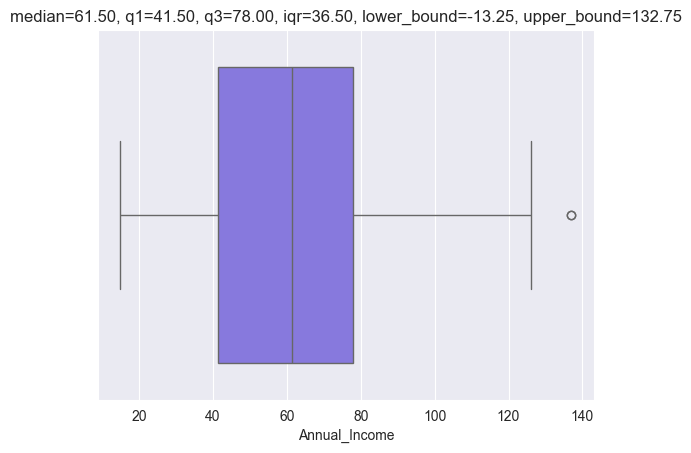

Spending_Score has 0 outliers


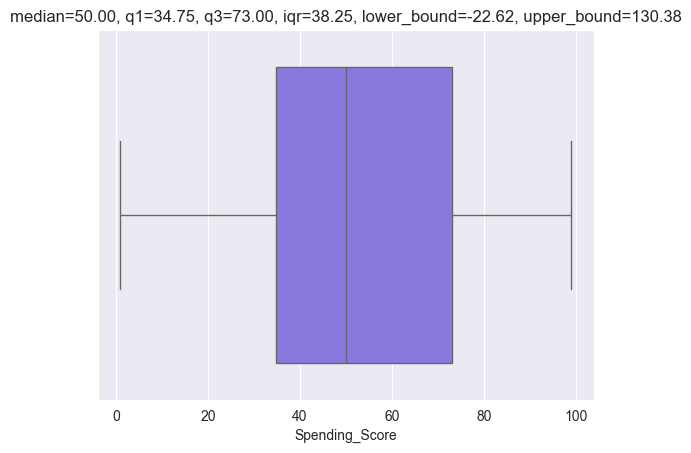

In [374]:
# Iterate through the numeric columns of the dataset to plot the outliers and describe the distribution of the variables.
for column in (df.select_dtypes(include=['float64','int64']).columns):
    print(f"{column} has {count_outliers(df, column)} outliers")
    boxplot(df, column)


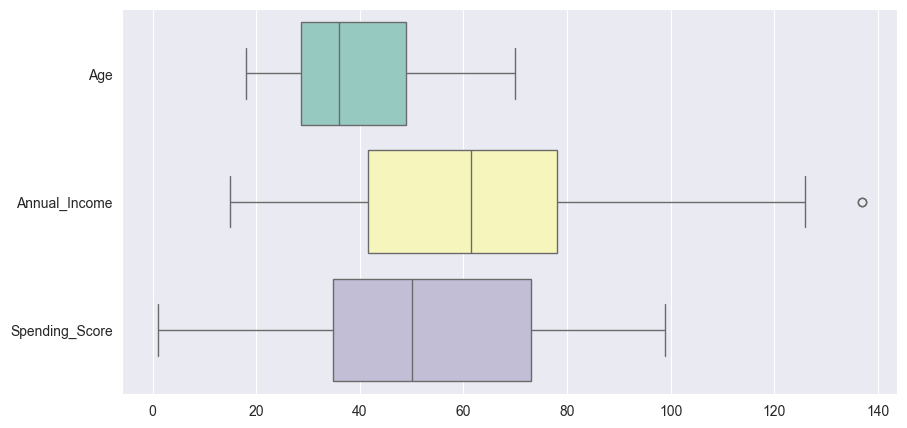

In [375]:
# Putting all the boxplots together
plt.figure(figsize = (10,5))
sns.boxplot(data = df, orient="h", palette="Set3")

plt.show()

In [376]:
df = remove_all_outliers(df)

2 Outliers removed


As we had only 2 outliers in our dataset (from the annual income), the best approach was to eliminate these extreme values.

#### Univariate analysis

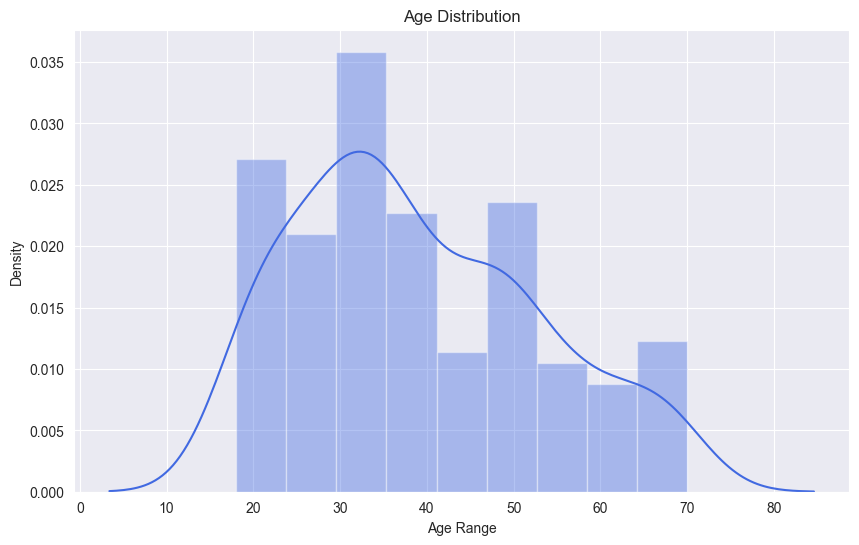

In [377]:
# Checking Age Distribution

plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

sns.histplot(df["Age"], kde=True,
            stat="density", kde_kws=dict(cut=3),
            alpha=.4, edgecolor=(1, 1, 1, .4),
            color="royalblue")
plt.title("Age Distribution")
plt.xlabel("Age Range")
plt.ylabel("Density")

plt.show()

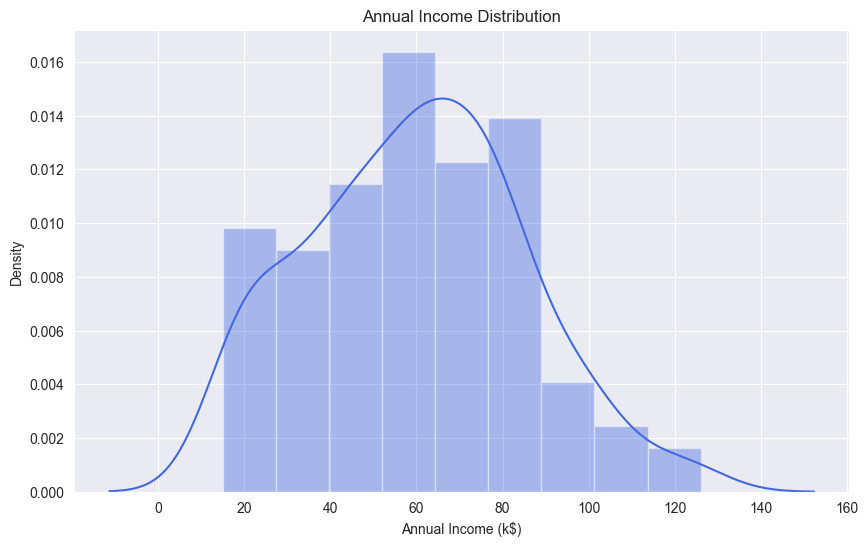

In [378]:
# Annual Income (k$) Distribution

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.histplot(df["Annual_Income"],  kde=True,
            stat="density", kde_kws=dict(cut=3),
            alpha=.4, edgecolor=(1, 1, 1, .4),
            color="royalblue")
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Density")
plt.show()


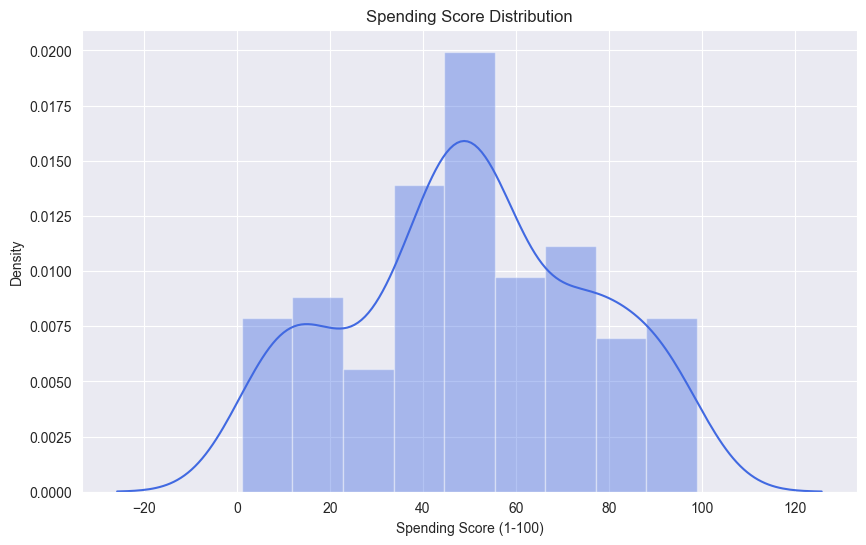

In [379]:
# Spending Score Distribution

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.histplot(df["Spending_Score"], kde=True,
            stat="density", kde_kws=dict(cut=3),
            alpha=.4, edgecolor=(1, 1, 1, .4),
            color="royalblue")
plt.title("Spending Score Distribution")
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Density")
plt.show()

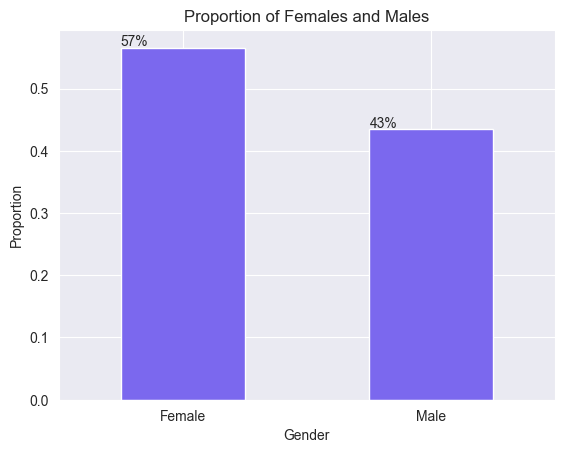

In [380]:
gender_plot=df.Gender.value_counts(normalize=True).plot.bar(ylabel='Proportion', title='Proportion of Females and Males', rot =0, color= "mediumslateblue")
plt.ticklabel_format(style="plain", axis="y")
for p in gender_plot.patches:
    gender_plot.annotate(str(round(p.get_height()*100))+'%', (p.get_x() * 1.005, p.get_height() * 1.005))

##### Bivariate Analysis

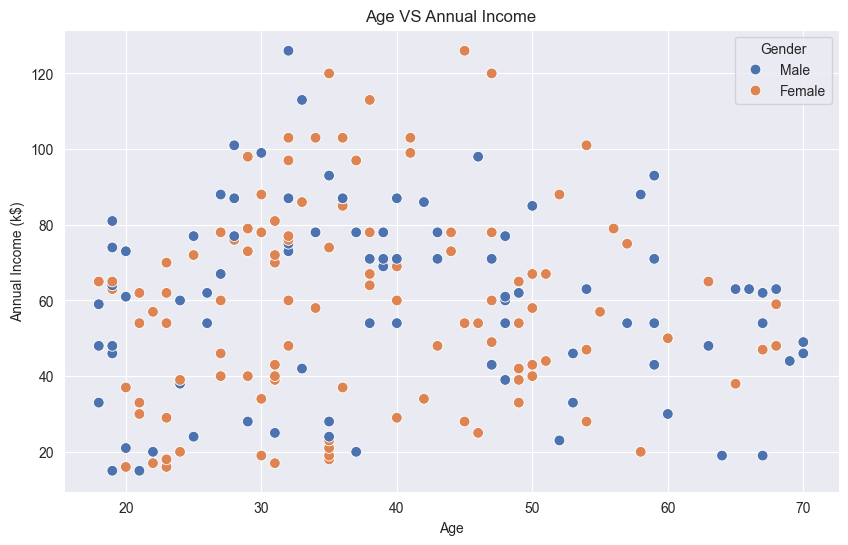

In [381]:
# Age VS Anual Income

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.scatterplot(data=df, x="Age", y= "Annual_Income", hue="Gender", s=60, palette="deep")
plt.title("Age VS Annual Income")
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
plt.show()

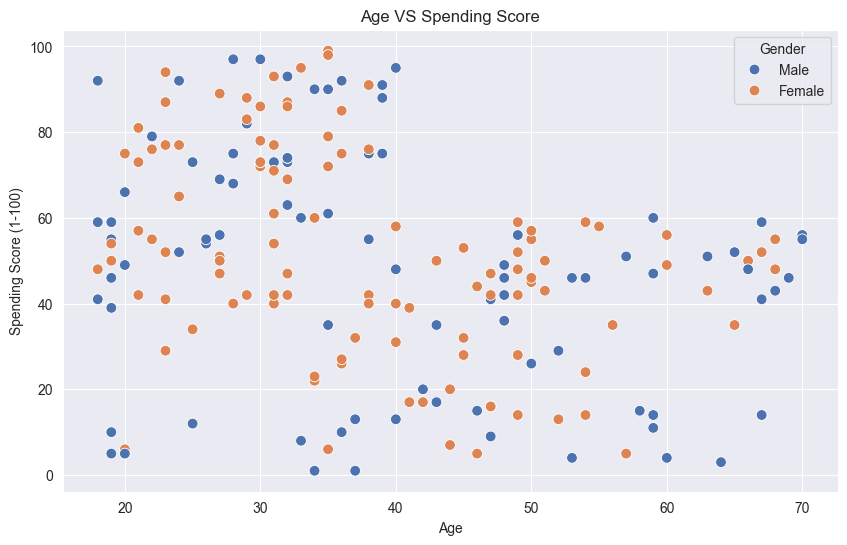

In [382]:
# Age VS Spending Score

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.scatterplot(data=df, x="Age", y= "Spending_Score", hue="Gender", s=60, palette="deep")
plt.title("Age VS Spending Score")
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")
plt.show()

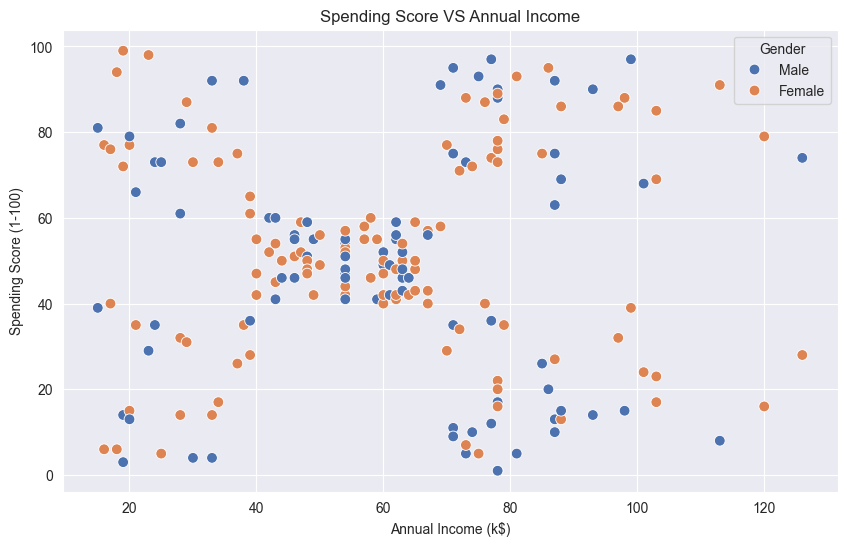

In [383]:
# Spending Score VS Anual Income

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.scatterplot(data=df, x="Annual_Income", y= "Spending_Score", hue="Gender", s=60, palette="deep")
plt.title("Spending Score VS Annual Income")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

##### Correlation Analysis

In [384]:
enc=OneHotEncoder() #Instantiate the object
#Create the columns with their respective name, and with the fit transform I assign a value of 1 or 0, and pass it to 
#an array to create the new dataframe
aux=pd.DataFrame(enc.fit_transform(df[['Gender']]).toarray(), columns=['F', 'M'])  
df=df.join(aux)
df=df.drop(['Gender'], axis=1)

<Axes: >

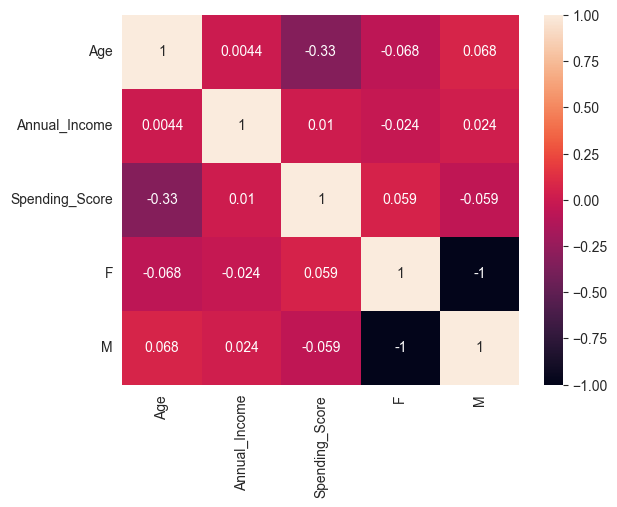

In [385]:
sns.heatmap(df.corr(),
           annot=True)